# LISA MCMC demo
This code uses an MCMC to sample parameters of a toy gravitational wave signal buried in coloured LISA like noise. The waveform model we will use is

$$ h(t;a,f,\dot{f}) = a \sin \left(2\pi t \left[f + \frac{1}{2}\dot{f}t\right]\right) $$

and we aim to estimate the parameter set $\boldsymbol{\theta} = \{a,f,\dot{f}\}$ using various samplers


In [1]:
from scipy.signal.windows import tukey

def PowerSpectralDensity(f):
    """
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf
    Removed galactic confusion noise. Non stationary effect.
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**-3

    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise

    PSD = ((10/(3*L**2))*(Poms + (4*Pacc)/((2*np.pi*f))**4)*(1 + 0.6*(f/f0)**2)) # PSD

    return PSD


def zero_pad(data):
    """
    This function takes in a vector and zero pads it so it is a power of two.
    We do this for the O(Nlog_{2}N) cost when we work in the frequency domain.
    """
    N = len(data)
    pow_2 = np.ceil(np.log2(N))
    return np.pad(data,(0,int((2**pow_2)-N)),'constant')

def FFT(waveform):
    """
    Here we taper the signal, pad and then compute the FFT. We remove the zeroth frequency bin because
    the PSD (for which the frequency domain waveform is used with) is undefined at f = 0.
    """
    N = len(waveform)
    taper = tukey(N,0.1)
    waveform_w_pad = zero_pad(waveform*taper)
    return np.fft.rfft(waveform_w_pad)[1:]

def freq_PSD(waveform_t,delta_t):
    """
    Here we take in a waveform and sample the correct fourier frequencies and output the PSD. There is no
    f = 0 frequency bin because the PSD is undefined there.
    """
    n_t = len(zero_pad(waveform_t))
    freq = np.fft.rfftfreq(n_t,delta_t)[1:]
    PSD = PowerSpectralDensity(freq)

    return freq,PSD

def inner_prod(sig1_f,sig2_f,PSD,delta_t,N_t):
    # Compute inner product. Useful for likelihood calculations and SNRs.
    return (4*delta_t/N_t) * np.real(sum(np.conjugate(sig1_f)*sig2_f/PSD))

def waveform(a,f,fdot,t,eps = 0):
    """
    This is a function. It takes in a value of the amplitude $a$, frequency $f$ and frequency derivative $\dot{f}
    and a time vector $t$ and spits out whatever is in the return function. Modify amplitude to improve SNR.
    Modify frequency range to also affect SNR but also to see if frequencies of the signal are important
    for the windowing method. We aim to estimate the parameters $a$, $f$ and $\dot{f}$.
    """

    return (a *(np.sin((2*np.pi)*(f*t + 0.5*fdot * t**2))))


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def llike(data_f, signal_f, variance_noise_f):
    """
    Computes log likelihood
    Assumption: Known PSD otherwise need additional term
    Inputs:
    data in frequency domain
    Proposed signal in frequency domain
    Variance of noise
    """
    inn_prod = sum((abs(data_f - signal_f)**2) / variance_noise_f)
    # print(inn_prod)
    return(-0.5 * inn_prod)


def lprior_uniform(param,param_low_val,param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

def lpost(data_f,signal_f, variance_noise_f,param1,param2,param3, param1_low_range = -10,param1_high_range = 10,
                                                   param2_low_range = -10,param2_high_range = 10,
                                                    param3_low_range = -10,param3_high_range = 10):
    '''
    Compute log posterior - require log likelihood and log prior.
    '''
    return(lprior_uniform(param1,param1_low_range,param1_high_range) +
                lprior_uniform(param2,param2_low_range,param2_high_range) +
                    lprior_uniform(param3,param3_low_range,param3_high_range) + llike(data_f,signal_f,variance_noise_f))


def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

def MCMC_run(data_f, t, variance_noise_f,
                   Ntotal, param_start, printerval = 200,
                   a_var_prop = 1e-23, f_var_prop = 1e-9, fdot_var_prop = 1e-13):
    '''
    Metropolis MCMC sampler
    '''

    plot_direc = os.getcwd() + "/plots"
    # Set starting values

    a_chain = [param_start[0]]
    f_chain = [param_start[1]]
    fdot_chain = [param_start[2]]

    # Initial signal

    signal_init_t = waveform(a_chain[0],f_chain[0],fdot_chain[0],t)   # Initial time domain signal
    signal_init_f = FFT(signal_init_t)  # Intial frequency domain signal

    # for plots -- uncomment if you don't care.

    params =[r"$\log_{10}(a)$", r"$\log_{10}(f)$", r"$\log_{10}(\dot{f})$"]
    N_param = len(params)
    np.random.seed(1234)
    signal_prop_f = signal_init_f

    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_f, signal_init_f, variance_noise_f, a_chain[0], f_chain[0],fdot_chain[0]))  # Append first value of log posterior

    lp_store = lp[0]  # Create log posterior storage to be overwritten

    #####
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):

        if i % printerval == 0: # Print accept/reject ratio.
            accept_reject_ratio = sum(accept_reject_count)/len(accept_reject_count)
            tqdm.write("Iteration {0}, accept_reject = {1}".format(i,accept_reject_ratio))

        lp_prev = lp_store  # Call previous stored log posterior

        # Propose new points according to a normal proposal distribution of fixed variance

        a_prop = a_chain[i - 1] + np.random.normal(0, np.sqrt(a_var_prop))
        f_prop = f_chain[i - 1] + np.random.normal(0, np.sqrt(f_var_prop))
        fdot_prop = fdot_chain[i - 1] + np.random.normal(0, np.sqrt(fdot_var_prop))

        # Propose a new signal
        signal_prop_t = waveform(a_prop,f_prop,fdot_prop,t)
        signal_prop_f = FFT(signal_prop_t)


        # Compute log posterior
        lp_prop = lpost(data_f,signal_prop_f, variance_noise_f,
                        a_prop, f_prop, fdot_prop)

        ####
        # Perform accept_reject call
        ####
        # breakpoint()
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            f_chain.append(f_prop)    # accept a_{prop} as new sample
            a_chain.append(a_prop)    # accept f_{prop} as new sample
            fdot_chain.append(fdot_prop)    # accept \dot{f}_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
        else:  # Reject, if this is the case we use previously accepted values
            a_chain.append(a_chain[i - 1])
            f_chain.append(f_chain[i - 1])
            fdot_chain.append(fdot_chain[i - 1])
            accept_reject_count.append(0)

        lp.append(lp_store)

    # Recast as .nparrays

    a_chain = np.array(a_chain)
    f_chain = np.array(f_chain)
    fdot_chain = np.array(fdot_chain)


    return a_chain,f_chain, fdot_chain,lp  # Return chains and log posterior.

In [3]:
import numpy as np


import matplotlib.pyplot as plt
from corner import corner
np.random.seed(1234)

# Set true parameters. These are the parameters we want to estimate using MCMC.

a_true = 5e-21
f_true = 1e-3
fdot_true = 1e-8

tmax =  120*60*60                 # Final time
fs = 2*f_true                     # Sampling rate
delta_t = np.floor(0.01/fs)       # Sampling interval -- largely oversampling here.

t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]

N_t = int(2**(np.ceil(np.log2(len(t)))))   # Round length of time series to a power of two.
                                           # Length of time series

h_true_f = FFT(waveform(a_true,f_true,fdot_true,t))         # Compute true signal in
                                                            # frequency domain. Real signal so only considering
                                                            # positive frequencies here.

freq,PSD = freq_PSD(t,delta_t)  # Extract frequency bins and PSD.

SNR2 = inner_prod(h_true_f,h_true_f,PSD,delta_t,N_t)    # Compute optimal matched filtering SNR
print("SNR of source",np.sqrt(SNR2))
variance_noise_f = N_t * PSD / (4 * delta_t)            # Calculate variance of noise, real and imaginary.



SNR of source 188.1310985137981


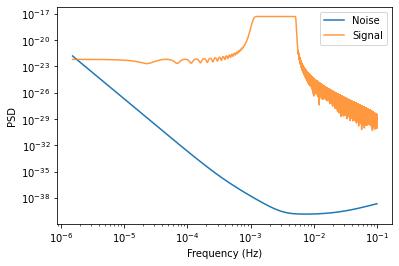

In [26]:
plt.loglog(freq,PSD, color='tab:blue', label = "Noise")
plt.plot(freq,np.absolute(h_true_f), alpha = 0.8, color='tab:orange', label = "Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend()

In [4]:

N_f = len(variance_noise_f)                             # Length of signal in frequency domain
np.random.seed(1235)                                    # Set the seed

# Generate frequency domain noise
noise_f = np.random.normal(0,np.sqrt(variance_noise_f),N_f) + 1j*np.random.normal(0,np.sqrt(variance_noise_f),N_f)

data_f = h_true_f + noise_f         # Construct data stream



In [5]:
# MCMC - parameter estimation

Ntotal = 30000  # Total number of iterations
burnin = 6000   # Set burn-in. This is the amount of samples we will discard whilst looking
             # for the true parameters

variance_noise_f = N_t * PSD / (4 * delta_t)

delta_a = np.sqrt(7.8152977583191198e-46)
delta_f = np.sqrt(3.122370011848878e-17)
delta_dotf = np.sqrt(1.007508992696005e-27)

param_start = [a_true + 1000*delta_a, f_true + 750*delta_f, fdot_true - 750*delta_dotf]  # Starting values
true_vals = [a_true,f_true, fdot_true]   # True values

a_chain,f_chain,fdot_chain,lp  = MCMC_run(data_f, t, variance_noise_f,
                            Ntotal, param_start,
                            printerval = 5000,
                            a_var_prop = delta_a**2,
                            f_var_prop = delta_f**2,
                            fdot_var_prop = delta_dotf**2)

print("Now printing summary statistics:")
print("Posterior mean value is E(a) = {0}, and standard deviation delta_a = {1}".format(np.mean(a_chain[burnin:]),np.sqrt(np.var(a_chain[burnin:]))))
print("Posterior mean value is E(f) = {0}, and standard deviation delta_f = {1}".format(np.mean(f_chain[burnin:]), np.sqrt(np.var(f_chain[burnin:]))))
print("Posterior mean value is E(fdot) = {0}, and standard deviation is delta_fdot = {1}".format(np.mean(fdot_chain),np.sqrt(np.var(fdot_chain[burnin:]))))



 17%|█▋        | 5012/29999 [00:56<04:38, 89.71it/s]

Iteration 5000, accept_reject = 0.4658


 33%|███▎      | 10014/29999 [01:53<03:45, 88.50it/s]

Iteration 10000, accept_reject = 0.389


 50%|█████     | 15011/29999 [02:53<02:57, 84.30it/s]

Iteration 15000, accept_reject = 0.36173333333333335


 67%|██████▋   | 20009/29999 [03:48<01:42, 97.34it/s] 

Iteration 20000, accept_reject = 0.3505


 83%|████████▎ | 25016/29999 [04:40<00:51, 96.46it/s] 

Iteration 25000, accept_reject = 0.34268


100%|██████████| 29999/29999 [05:38<00:00, 88.66it/s] 

Now printing summary statistics:
Posterior mean value is E(a) = 5.015937502495481e-21, and standard deviation delta_a = 2.7027918329014523e-23
Posterior mean value is E(f) = 0.001000006499867159, and standard deviation delta_f = 1.4632842491465573e-08
Posterior mean value is E(fdot) = 9.997046214647843e-09, and standard deviation is delta_fdot = 8.566838045669753e-14


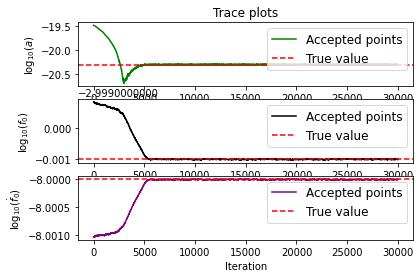

<Figure size 432x288 with 0 Axes>

In [6]:

params = [r'$\log_{10}(a)$', r'$\log_{10}(f_{0})$', r'$\log_{10}(\dot{f}_{0})$']  # Set parameter labels
N_params = len(params)   # Set number of parameters to investigate
true_vals_for_plot = [np.log10(true_vals[0]),np.log10(true_vals[1]), np.log10(true_vals[2])]  # Set true values (log)

# Plot trace plot

a_chain_log = np.log10(a_chain)
f_chain_log = np.log10(np.array(f_chain))
fdot_chain_log = np.log10(np.array(fdot_chain))
samples = [a_chain_log, f_chain_log, fdot_chain_log]  # Store samples in a list
color = ['green','black','purple']  # Set pretty colours

fig,ax = plt.subplots(3,1)
for k in range(0,3):
    ax[k].plot(samples[k], color = color[k],label = "Accepted points")
    ax[k].axhline(y = true_vals_for_plot[k],c = 'red', linestyle='dashed', label = 'True value', )
    ax[k].set_xlabel('Iteration',fontsize = 10)
    ax[k].set_ylabel(params[k], fontsize = 10)
    ax[k].legend(loc = "upper right", fontsize = 12)
ax[0].set_title("Trace plots")
plt.show()
plt.clf()


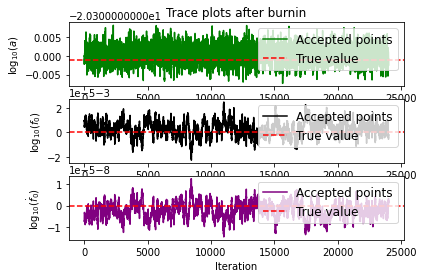

<Figure size 432x288 with 0 Axes>

In [7]:

# Plot trace plot after burnin

a_chain_log_burnin = a_chain_log[burnin:]   # Discard the first 0, ..., burnin samples from each chain
f_chain_log_burnin = f_chain_log[burnin:]
fdot_chain_log_burnin = fdot_chain_log[burnin:]
samples_burned = [a_chain_log_burnin, f_chain_log_burnin, fdot_chain_log_burnin]

fig,ax = plt.subplots(3,1)
for k in range(0,3):
    ax[k].plot(samples_burned[k], color = color[k],label = "Accepted points")
    ax[k].axhline(y = true_vals_for_plot[k],c = 'red', linestyle='dashed', label = 'True value')
    ax[k].set_xlabel('Iteration',fontsize = 10)
    ax[k].set_ylabel(params[k], fontsize = 10)
    ax[k].legend(loc = "upper right", fontsize = 12)
ax[0].set_title("Trace plots after burnin")
plt.show()
plt.clf()


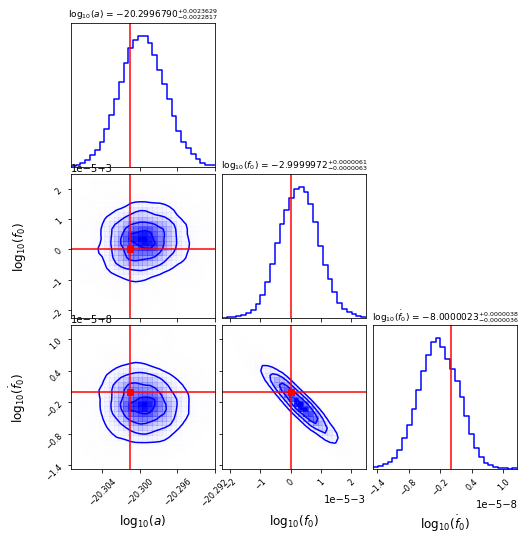

<Figure size 432x288 with 0 Axes>

In [8]:

# Plot corner plot

samples = np.column_stack(samples_burned)  # Stack samples to plot corner plot
figure = corner(samples,bins = 30, color = 'blue',plot_datapoints=False,smooth1d=True,
                    labels=params,
                    label_kwargs = {"fontsize":12},set_xlabel = {'fontsize': 20},
                    show_titles=True, title_fmt='.7f',title_kwargs={"fontsize": 9},smooth = True)

axes = np.array(figure.axes).reshape((N_params, N_params))

for k in range(N_params):   # Plot true values on corner plot (diagonals)
    ax = axes[k, k]
    ax.axvline(true_vals_for_plot[k], color="r")

for yi in range(N_params):  # Plot true values on corner plot (non-diagonals)
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axhline(true_vals_for_plot[yi], color="r")
        ax.axvline(true_vals_for_plot[xi],color= "r")
        ax.plot(true_vals_for_plot[xi], true_vals_for_plot[yi], "sr")

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=8)   # Set font of labels
plt.show()
plt.clf()